# Import dependencies

In [1]:
!pip install keras

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install cython

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import sys
sys.path.append('Mask_RCNN')

In [4]:
!pip install imageio

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install scikit-image

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install torch torchvision

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import os
import sys
import random
import math
import re
import time
import gc; gc.enable()

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
#sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel
from preparation import vgg_feature_extractor
from random import *

import gc; gc.enable()
import utils
import model as modellib
import visualize
from model import log

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's download the mask_rcnn trained on COCO dataset to initialize the model.

In [8]:
pd.options.display.max_rows=100

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

We will now define the monitor that will help keep track on the training process.
With this you will be able to see your charts in the `charts` tab

Now we will load the metadata and divide them in train and valid splits

In [9]:
TRAIN_PATH = '../stage1_train'
TEST_PATH = '../stage2_test_final'
META_DATA_PATH = '../stage2_metadata.csv'
BG_DATA_PATH = '../stage2_foreground_background_classes.csv'

In [10]:
if not os.path.exists(META_DATA_PATH):
    print('Generating stage2_metadata.csv')
    
    stage1_metadata = pd.DataFrame()
    
    train_image_ids = os.listdir(TRAIN_PATH) # ImageId
    train_is_train = [1] * len(train_image_ids)
    
    train_file_path = []
    for p in train_image_ids:
        if p[:4] == 'TCGA':
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.tif')
        else:
            train_file_path.append(TRAIN_PATH + '/' + p + '/images/' + p + '.png')
    
    test_image_ids = os.listdir(TEST_PATH) # ImageId
    test_is_train = [0] * len(test_image_ids)
    test_file_path = [TEST_PATH + '/' + p + '/images/' + p + '.png' for p in test_image_ids]
    
    stage1_metadata['ImageId'] = np.concatenate([train_image_ids, test_image_ids], axis=0)
    stage1_metadata['is_train'] = np.concatenate([train_is_train, test_is_train], axis=0)
    stage1_metadata['file_path_image'] = np.concatenate([train_file_path, test_file_path], axis=0)
    
    
    ve = vgg_feature_extractor(n_clusters=10)
    train_vgg_features_clusters = ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 1].reset_index(drop=True), is_train=True)
    test_vgg_features_clusters =ve.get_vgg_clusters(stage1_metadata[stage1_metadata.is_train == 0].reset_index(drop=True), is_train=False)
    
    stage1_metadata['vgg_features_clusters'] = np.concatenate([train_vgg_features_clusters, test_vgg_features_clusters], axis=0)
    
    
    stage1_metadata.to_csv(META_DATA_PATH, index=False)
    meta = stage1_metadata
    
    #del vgg_feature_extractor; gc.collect()
else:
    meta = pd.read_csv(META_DATA_PATH)
    

meta.head(100)

,ImageId,is_train,file_path_image,vgg_features_clusters
0,ef6634efb46567d87b811be786b18c4cd0e2cda23d79b6...,1,../stage1_train/ef6634efb46567d87b811be786b18c...,1
1,351771edfc5db5665ded8aa4940257276b6526663c76e3...,1,../stage1_train/351771edfc5db5665ded8aa4940257...,6
2,785555c0cbb49dad835635217085287a8cc61c27d26f0e...,1,../stage1_train/785555c0cbb49dad83563521708528...,4
3,7ba20aa731cc21af74a8d940254176cbad1bdc44f240b5...,1,../stage1_train/7ba20aa731cc21af74a8d940254176...,1
4,43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1f...,1,../stage1_train/43cf6b2ec0b0745ac2b87b4d8780f6...,3
5,0b2e702f90aee4fff2bc6e4326308d50cf04701082e718...,1,../stage1_train/0b2e702f90aee4fff2bc6e4326308d...,4
6,61dc249314d7b965eb4561ec739eab9b0f60af55c97b25...,1,../stage1_train/61dc249314d7b965eb4561ec739eab...,6
7,28d33efef218392e79e385906deb88055d94b65ad217de...,1,../stage1_train/28d33efef218392e79e385906deb88...,0
8,4596961c789d3b41916492918797724fe75128239fefc5...,1,../stage1_train/4596961c789d3b4191649291879772...,6
9,1ec74a26e772966df764e063f1391109a60d803cff9d15...,1,../stage1_train/1ec74a26e772966df764e063f13911...,9


In [11]:
meta.tail(100)

,ImageId,is_train,file_path_image,vgg_features_clusters
3613,5d71876e8bba86a57c3e92947fa58ffafacc5e56052f38...,0,../stage2_test_final/5d71876e8bba86a57c3e92947...,6
3614,88c7fba66a016ceaa25abba59e8b6739df21a102aeffd1...,0,../stage2_test_final/88c7fba66a016ceaa25abba59...,0
3615,fb11432e1637804c44c66fa7a02c28886ebcfc4ae2bb9c...,0,../stage2_test_final/fb11432e1637804c44c66fa7a...,4
3616,364fb54d8bcbf2d67da60c3c1f6bade82c6a72f76010e6...,0,../stage2_test_final/364fb54d8bcbf2d67da60c3c1...,0
3617,4716505b5e5a718d5669f2be196c4fa463711a5ba23e7b...,0,../stage2_test_final/4716505b5e5a718d5669f2be1...,0
3618,c73216e5dd0e7897e18e93fe8aa78479d38eed66356003...,0,../stage2_test_final/c73216e5dd0e7897e18e93fe8...,4
3619,43db90aa201fdd722138d1b4ebd4ef45c060c9ab349556...,0,../stage2_test_final/43db90aa201fdd722138d1b4e...,5
3620,5694ef74699c2a74bb6d6cc04af7432c29ccd4a0940716...,0,../stage2_test_final/5694ef74699c2a74bb6d6cc04...,0
3621,e0946fa9d9828d41ef95aad92c052bc09f41a986b7120b...,0,../stage2_test_final/e0946fa9d9828d41ef95aad92...,4
3622,5171307b70da8e144e5ace020a85a985af8c11360297cc...,0,../stage2_test_final/5171307b70da8e144e5ace020...,4


In [12]:
back_ground_df = pd.read_csv(BG_DATA_PATH)
back_ground_df.tail(100)

,ImageId,bg_type
2919,f712caa5d4ec696c143dee607100664f983820cee20b5a...,bw
2920,f749bd3d0801a25581ebdecb696f4883c13e2f44ae071a...,bw
2921,f7525279fa7d5896baf5dfb8b7535e0f4b5f19f2deed19...,bw
2922,f76ae9f189bdb18a7ce90ddc760388cef13785866c1610...,bw
2923,f77e0a7408802b56ad0d44915a882003dc048a8c04baf5...,bw
2924,f7a5c69c3908e4a7443722bc0a59f998afff7735ae63a8...,bw
2925,f7a6b7d515d1dc27915128663085998f978bdc5e9917f9...,bw
2926,f7ad1329e948e9a540af770c2af37c235144d014aae3a0...,bw
2927,f7c60564c8da0a484eb81b011f8fcc46c5749d20b012d0...,bw
2928,f7c7666bd0e4a6a3abc0be51479133df8f77d649203aa5...,bw


In [13]:
back_ground_df = back_ground_df.set_index('ImageId')
back_ground_df.head(10)

,bg_type
ImageId,
0019c086029dd3be01f72131edb74e21ee995574e6d5c136ea868630b0d73523,he
004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf,bw
005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed,bw
005af293e8e53218ae96746ecf9bb88b511154d4a0b35e4ec6296b4623e15836,bw
005d47447abac7f7fa0ac56ba82f13edbf485105baf0672504d84b58d562f38b,bw
00ac87390253a22f6eb67c5771a73050e06200d1aa682fcf1b1e3783b2944166,bw
00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd27200d02dca6966b83,bw
00da4fe5346bbb36ccf178964a22fdf7e33888989624176a6af3b4a7cfd7da63,bw
00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380bf74985cbe641086806,bw


In [14]:
meta = meta[meta['is_train'] == 0].reset_index(drop=True)

In [15]:
meta['bg_type'] = meta.ImageId.map(back_ground_df.bg_type)

In [16]:
meta['process_type'] = meta['bg_type'].map({
    'bw': 2, # do nothing
    'wb': 3, # pure reverse
    'he': 2, # do nothing
    'c_bw': 0, # turns into gray 
    'c_wb': 1, # turns into gray and reverse
})
meta['process_type'].value_counts()

2    3016
1       2
3       1
Name: process_type, dtype: int64

In [17]:
meta['group'] = meta['bg_type'].map({
    'bw': 0, # do nothing
    'wb': 0, # pure reverse
    'he': 1, # do nothing
    'c_bw': 0, # turns into gray 
    'c_wb': 0, # turns into gray and reverse
})
meta['group'].value_counts()

0    2803
1     216
Name: group, dtype: int64

In [18]:
meta_test = meta

# Mask-RCNN configuration
We will now define parameters for our mask-rcnn. 
Tweak them to get better results!

In [19]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14 # 14
    MASK_SHAPE = [28, 28] # 28
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_DETECTION_MIN_CONFIDENCE = .6
    RPN_NMS_THRESHOLD = 0.6 #0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 450 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.67 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    # DETECTION_MAX_INSTANCES=400, DETECTION_MIN_CONFIDENCE=.7 => Val loss: .21xx, LB: .424
    # DETECTION_MAX_INSTANCES=450, DETECTION_MIN_CONFIDENCE=.65 => Val loss: .3, LB: .438
    # DETECTION_MAX_INSTANCES=, DETECTION_MIN_CONFIDENCE= => Val loss: ., LB: .
    
    '''
    0324 note: 
        RPN_NMS_THRESHOLD .7 -> .6 to generate more proposals at training,
        DETECTION_MAX_INSTANCES 400 -> 450
        DETECTION_MIN_CONFIDENCE .7
        BACKBONE_STRIDES add `2` ..?
    '''
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
    # Min Box Size
    MIN_BOX_SIZE = 36./(512.**2.) # (36/512**2) (delete objects smaller than 6*6 pixels)
    BORDER_RATIO = 4. / 512. # smaller than 4 pixels width\height at the border
    BORDER_MIN_BOX_SIZE = 16./(512.**2.)
  
    LR_SHRINK_PERIOD = 10
    
config = DsbConfig()

# Dataset definition

We need to define our datasets for the data science bowl competition

In [20]:
from augment import Augment

class DsbDataset(utils.Dataset):
    '''
    process_info is a image-id <=> process type mapping pd.series
    '''
    def load_dataset(self, process_info, train_mode=True, augment=False):
        self.add_class("dsb", 1, "nuclei")
        self.process_info = process_info
        self.augmenter = Augment()
        self.augment = augment
        
        if train_mode:
            directory = dsb_dir
        else:
            directory = test_dir
            
        ids = []
        for i, id in enumerate(process_info.ImageId.values):
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            ids.append(i)
        
        self.process_info.reset_index(drop=True, inplace=True)
        #print(self.process_info)
        self.process_info['id'] = ids
        self.process_info.set_index('id')
        self.process_info = self.process_info['process_type']
        #print(self.process_info)
        
    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        
        #print(self.process_info[image_id])
        if image_path[-4:] == '.tif':
            self.offset = (randrange(488), randrange(488))
            image = image[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512, :]
            #image = skimage.transform.resize(image, (512,512),  preserve_range=True)
        
        try:
            if image.shape[2] != 3:
                image = image[:,:,:3]
        except:
            print(image)
            image = image / 255.
            image = skimage.color.gray2rgb(image.astype('uint8'))
            print('new\n', image)
            
        image = self.preprocess(image, process_type=self.process_info[image_id])
        image = image.astype('float32')
        
        if self.augment:
            self.augment_func = self.augmenter.get_random_augement()
            image = self.augment_func(image)
            
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
                
            if 'TCGA' in mask_dir:
                #msk = skimage.transform.resize(msk, (512,512), preserve_range=True)
                msk = msk[self.offset[0]:self.offset[0]+512, self.offset[1]:self.offset[1]+512]
                if np.sum(msk) == 0:
                    continue
                
            msk = msk.astype('float32')/255.
            
            if len(msk.shape) > 2:
                msk = np.sum(msk, axis=2)
                
            mask.append(msk)
            
        try:
            mask = np.array(mask)
        except:
            for i, m in enumerate(mask):
                if len(m.shape) > 2:
                    print(mask_names[i])
                    
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        if self.augment:
            mask = self.augment_func(mask) # self.augment_func was decided when loading image before loading masks
            
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img, process_type=0):
        if process_type == 0: # grey-rgb-grey
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
        elif process_type == 1:  # grey-rgb-grey-reverse
            gray = skimage.color.rgb2gray(img.astype('uint8'))
            img = skimage.color.gray2rgb(gray)
            img *= 255.
            img = 255. - img
        elif process_type == 2:
            img = img.astype(float) # do nothing
        elif process_type == 3:
            img = 255. - img
        
        return img

In [21]:
dsb_dir = TRAIN_PATH
test_dir = TEST_PATH

# Evaluate
I think we are ready to see how our model does on the validation!

In [22]:
class InferenceConfig(DsbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # MEAN_PIXEL = np.array([56.02288505, 54.02376286, 54.26675248])

    USE_FLEXIBLE_NMS = True
    DETECTION_MIN_CONFIDENCE = 0.88
    DETECTION_NMS_THRESHOLD = 0.3
    SNMS_METHOD = 2 # 0: normal greedy nms, 1: linear method 2: Gaussian method
    SNMS_SIGMA = 0.5

inference_config = InferenceConfig()

In [23]:
paths = ['logs/Final Models/partial_bw_50.h5',
         'logs/Final Models/partial_he_70.h5']

In [24]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [25]:
test_ids = os.listdir(test_dir)

In [26]:
def test_split(meta_test):
    meta_test_groups = [meta_test[meta_test['group'] == group].reset_index(drop=True) for group in range(2)]
    return meta_test_groups

In [27]:
meta_test_groups = test_split(meta_test)

In [28]:
test_datasets = []
for i in range(2):
    
    te = meta_test_groups[i]

    # Testing dataset
    dataset_test = DsbDataset()
    dataset_test.load_dataset(te[['ImageId', 'process_type']], train_mode=False)
    dataset_test.prepare()
    
    test_datasets.append(dataset_test)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
print(len(test_datasets[0].image_ids))

2803


In [30]:
print(len(test_datasets[1].image_ids))

216


In [31]:
from prediction_saver import prediction_saver

In [32]:
from time import time
start_time = time()
PRED_SAVER_DIR = os.path.join(ROOT_DIR, "prediction_savers_stage2_5070")
ps = prediction_saver(PRED_SAVER_DIR, meta_test.ImageId.values)

In [33]:
ACCEPT_RATIO = 1.6

In [34]:
print('TTA + Flexble Avg takes {:.3f} secs'.format(time()-start_time))
start_time = time()

TTA + Flexble Avg takes 0.053 secs


In [35]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [36]:
def numpy2encoding_no_overlap(predicts, img_name, scores):
    if len(scores) == 0:
        return [], []
    
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    #print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [37]:
new_test_ids = []
rles = []

def update_final_predictions(test_ids, predictions, new_test_ids, rles):
    
    for id, raw_pred in zip(test_ids, predictions):
        ids, rle = numpy2encoding_no_overlap(raw_pred[0], id, raw_pred[1])
        new_test_ids += ids
        rles += rle
    
    return new_test_ids, rles

processed_count = 0
(14, 4)
(256, 256, 14)
(14,)
(14,)


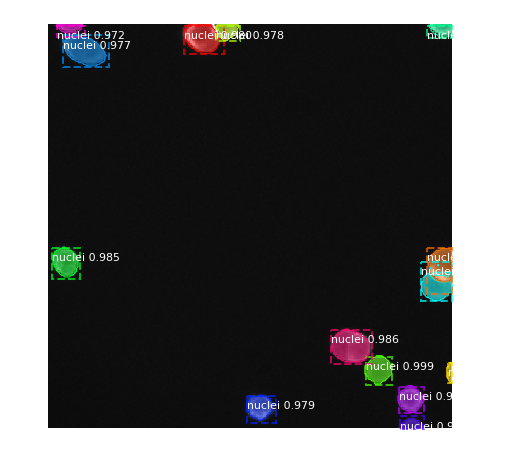

image  0  processed, bg type = bw 
id = 13ada12068b9d35f2a74ee5a9744b6091fa17eb737e72a48488b3b8e5c8afe97
image  1  processed, bg type = bw 
id = cbf1670753bb2b95ebb8f7b6a68e1238361c027f950275899c48f66b90c556d9
(4, 4)
(256, 256, 4)
(4,)
(4,)


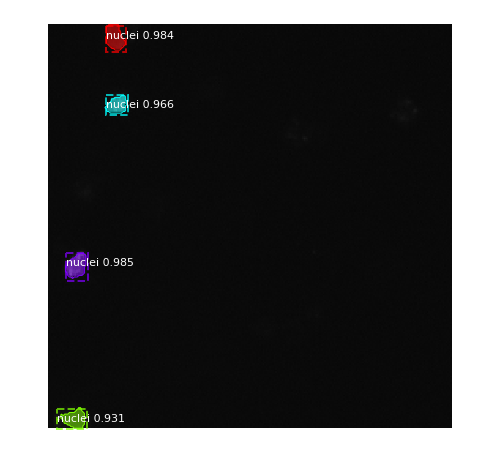

image  2  processed, bg type = bw 
id = a23bd67c0951c42d19342cdd6658b152952d265d32d8634c31a0cce1ed76af75
(127, 4)
(520, 696, 127)
(127,)
(127,)


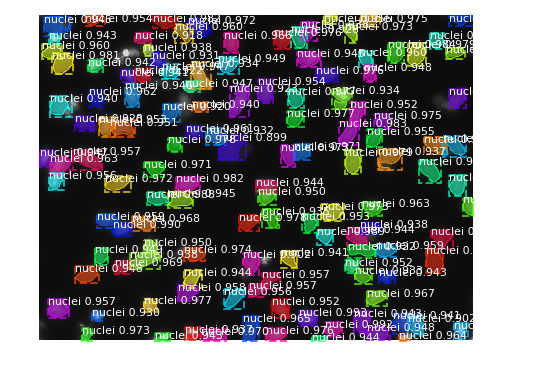

image  3  processed, bg type = bw 
id = 8842f82c1b98cb57046465393c4af55968a93995a5ad3cc20d28c415275ae87c
(1, 4)
(512, 512, 1)
(1,)
(1,)


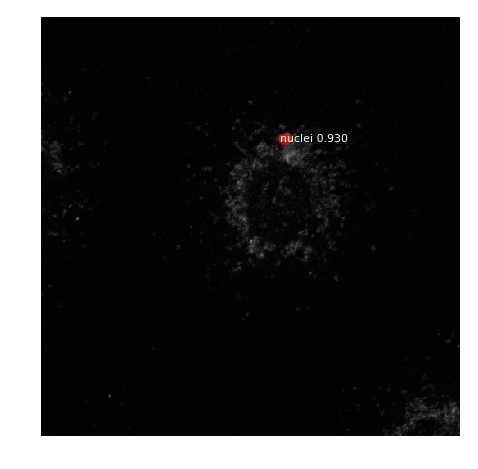

image  4  processed, bg type = bw 
id = 12e64a088a0c0c545de24786677383bfbe51ad5be5ab3812a1f38affb5694665
(7, 4)
(574, 574, 7)
(7,)
(7,)


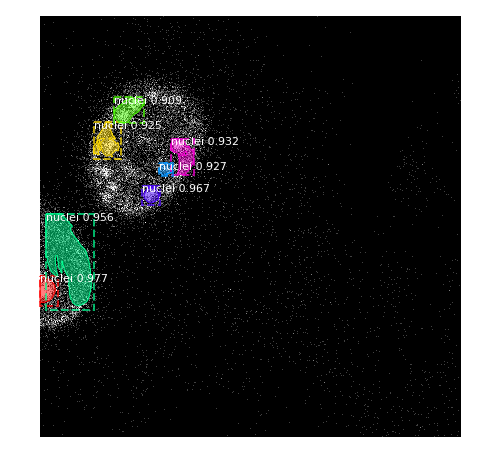

image  5  processed, bg type = bw 
id = 7de601fd01adf8779374fa9082421c4bc5e5b940fbc120f509660238cd4f8cc5
image  6  processed, bg type = bw 
id = 3256845310ed88c59805c285b46519848203263bbe7dce67c3f2a27e27b9c17e
(16, 4)
(256, 256, 16)
(16,)
(16,)


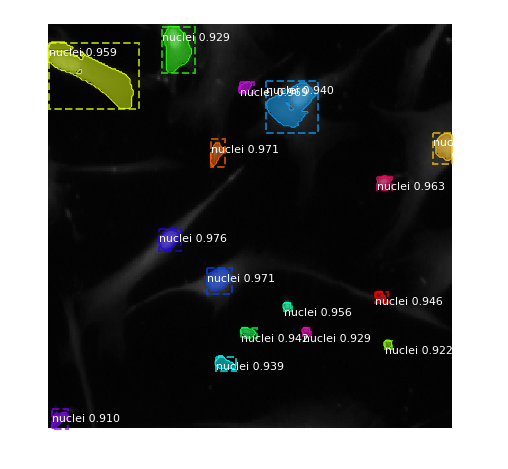

image  7  processed, bg type = bw 
id = bfe5d489404bf9228efe1a80763ca4f8cb9c2f8ca3ea6f3cbdb89fda64f8f450
(85, 4)
(520, 696, 85)
(85,)
(85,)


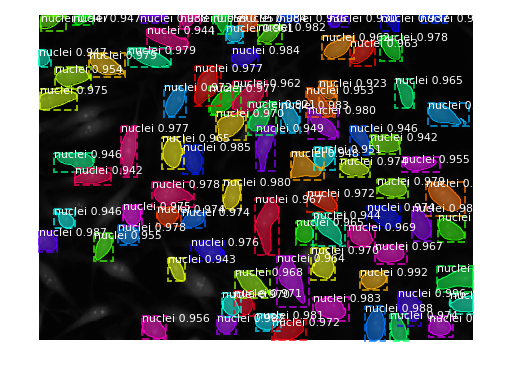

image  8  processed, bg type = bw 
id = b8284c831aa08dd5ede5fd89734045a297bd19559bae998f93ca01a1529abbed
image  9  processed, bg type = bw 
id = 2542a5402678b37129d9e55b541d716503d05018e988dcd859cafcc5a1a8eecf
(26, 4)
(256, 256, 26)
(26,)
(26,)


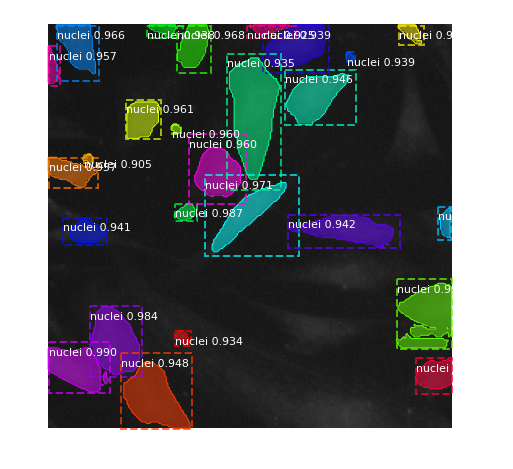

image  10  processed, bg type = bw 
id = 94f75d9ce083d08c25a0d7e2d6583c0aa4e2dfc0274b9d43806b9a3b5961d62e
(9, 4)
(256, 256, 9)
(9,)
(9,)


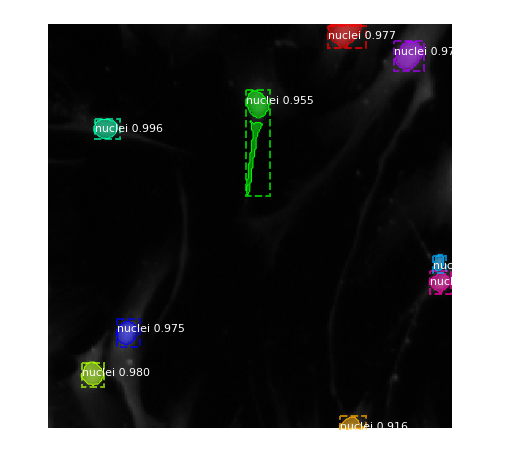

image  11  processed, bg type = bw 
id = 8313dab144d6cdba670db1ac439ca0721c20b6e7635ea3ad84132f62b077daec
(23, 4)
(512, 512, 23)
(23,)
(23,)


KeyboardInterrupt: 

In [38]:
TESTING_BATCH_SIZE = 1000
TO_VISUALIZE =True
gen_index = 0
count = [0, 700]

for i in range(2):
    test_index = i
    dataset_test = test_datasets[test_index]
    
    processed_count = 0
    
    if test_index == gen_index:
        processed_count = count[0]
    else:
        continue
        
    while processed_count < len(dataset_test.image_ids) and processed_count < count[1]:
        print('processed_count =', processed_count)
        selected_test_ids = dataset_test.image_ids[processed_count:processed_count+TESTING_BATCH_SIZE]
        
        raw_predictions = []
        image_ids = []
        for x, test_id in enumerate(selected_test_ids):
            image_id = meta_test_groups[test_index].ImageId.values[x+processed_count]
            pred = ps.load(image_id, is_final=True) 
        
            b_masks = []
            for mask in pred['masks']:
                # binarize
                b_masks.append(np.where(mask>=0.5, 1, 0).astype(np.uint8))
            
            if len(pred['scores']) > 0:
                new_masks = np.stack(b_masks, axis=2)
                boxes = np.array(pred['boxes'])
                scores = np.array(pred['scores'])
                class_ids = np.ones((len(pred['scores'],))).astype(np.uint8)

                #res[x]
                '''
                data = {
                   'boxes': res[i][0],
                   'masks': res[i][1],
                   'scores': res[i][2],
                   'class_ids': res[i][3],
                }
                filtered_boxes, filtered_masks, filtered_scores, filtered_class_ids, nb_filter_masks
                '''
                if TO_VISUALIZE is True and len(pred['boxes']) != 0:
                    test_image = dataset_test.load_image(test_id, 0)

                    print(boxes.shape)
                    print(new_masks.shape)
                    print(scores.shape)
                    print(class_ids.shape)

                    visualize.display_instances(test_image, boxes, new_masks, 
                                                class_ids, dataset_test.class_names, scores, ax=get_ax())

            print('image ', x+processed_count, 
                  ' processed, bg type =', meta_test_groups[test_index].bg_type.values[x+processed_count],
                  '\nid =', image_id)
            
            del pred; gc.collect()
        
        
        processed_count += len(selected_test_ids)

In [ ]:
print(len(new_test_ids))

In [ ]:
print(len(rles))

In [ ]:
print('Summarize TTA Results takes {:.3f} secs'.format(time()-start_time))